In [42]:
LANGUAGE = 'dutch'

### Setting Up

In [43]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from umap import UMAP
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

In [44]:
def load_results_dataframe(language: str) -> pd.DataFrame:
    df = pd.read_csv(f'https://scandeval.com/{language}-nlu.csv')

    datasets = ['model_id', 'rank']
    for task in ['ner', 'sent', 'la', 'qa']:
        datasets.extend([
            dataset
            for dataset in df.columns
            if dataset_to_task.get(dataset) == task
        ])
    df = df[datasets]
    
    df['generative'] = df.model_id.map(lambda x: "few-shot" in x)
    df.set_index('model_id', inplace=True)
    
    return df

In [45]:
dataset_to_task = dict(
    # Danish
    dansk='ner',
    angry_tweets='sent',
    scala_da='la',
    scandiqa_da='qa',

    # Norwegian
    norne_nb='ner',
    norne_nn='ner',
    norec='sent',
    scala_nb='la',
    scala_nn='la',
    norquad='qa',

    # Swedish
    suc3='ner',
    swerec='sent',
    scala_sv='la',
    scandiqa_sv='qa',

    # Icelandic
    mim_gold_ner='ner',
    scala_is='la',
    nqii='qa',

    # Faroese
    fone='ner',
    scala_fo='la',

    # German
    germeval='ner',
    sb10k='sent',
    scala_de='la',
    germanquad='qa',

    # Dutch
    conll_nl='ner',
    dutch_social='sent',
    scala_nl='la',
    squad_nl='qa',

    # English
    conll_en='ner',
    sst5='sent',
    scala_en='la',
    squad='qa',
)
language_title = LANGUAGE.replace('-', ' ').title()

In [46]:
df = load_results_dataframe(language=LANGUAGE)
df.head()

,rank,conll_nl,dutch_social,scala_nl,squad_nl,generative
model_id,,,,,,
intfloat/multilingual-e5-large,1.40,82.31,32.64,58.51,45.32,False
setu4993/LaBSE,1.48,82.02,33.99,60.77,41.55,False
DTAI-KULeuven/robbert-2022-dutch-base,1.75,79.84,24.58,68.76,27.63,False
gpt-4-1106-preview (few-shot),1.76,66.44,15.05,74.01,57.81,True
pdelobelle/robbert-v2-dutch-base,1.79,78.30,26.68,63.83,28.34,False


## Plots

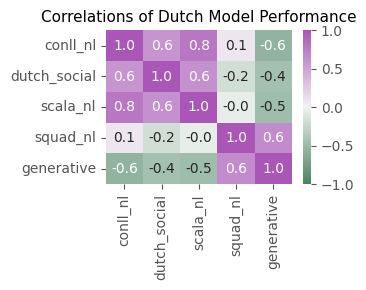

In [47]:
num_languages = (len(df.columns) - 1) // 4
plt.figure(figsize=(3 * num_languages, 2 * num_languages))
sns.heatmap(
    df.drop(columns='rank').corr(), 
    annot=True, 
    fmt=".1f", 
    vmin=-1, 
    vmax=1, 
    cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
)
plt.title(f"Correlations of {language_title} Model Performance", fontsize=9 + 2 * num_languages)
plt.savefig(f"/Users/dan/Downloads/correlation-{LANGUAGE}.png", bbox_inches='tight')
plt.show()

Using 73 neighbours.


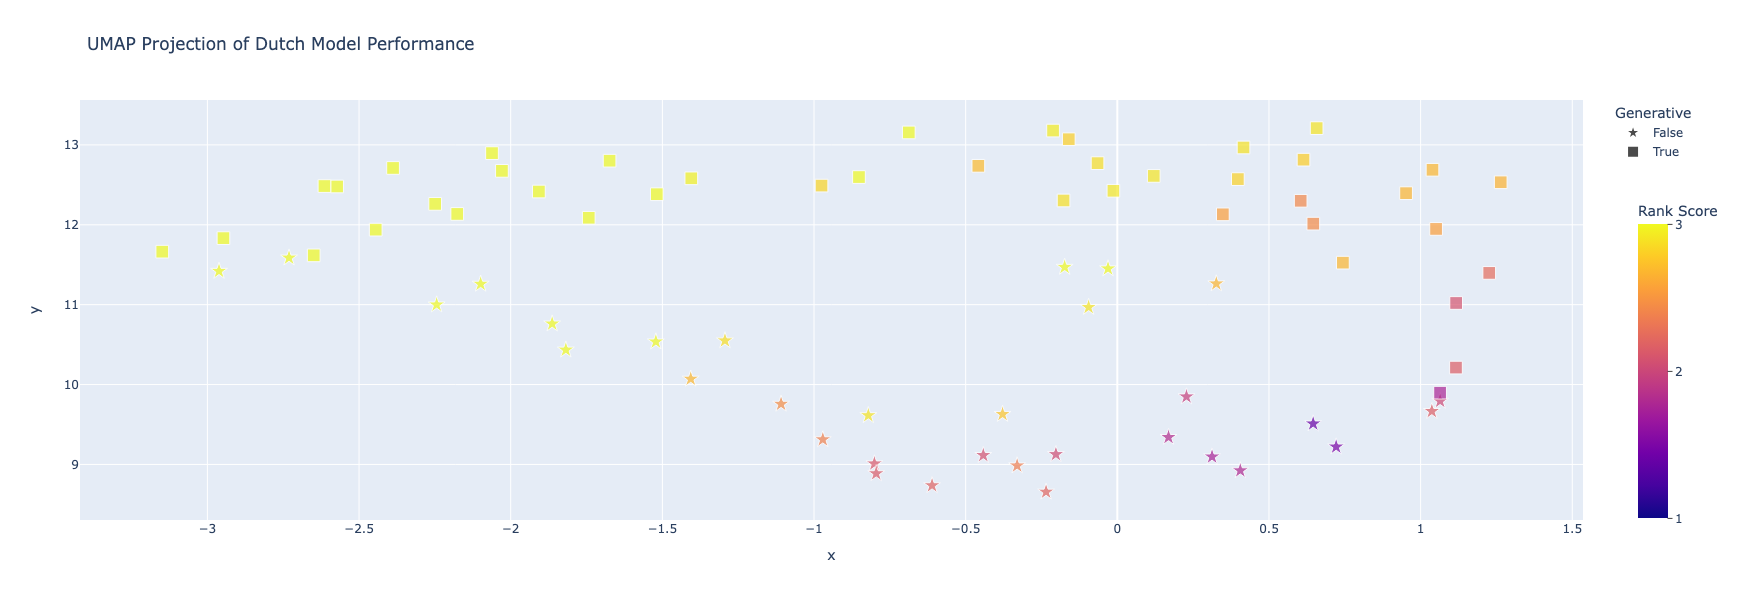

In [48]:
n_neighbours = len(df) - 1
print(f"Using {n_neighbours} neighbours.")
umap = UMAP(n_neighbors=n_neighbours, n_components=2, random_state=4242, n_jobs=1)
umap_projection = umap.fit_transform(df.drop(columns=["generative", "rank"]))

fig = px.scatter(
    x=umap_projection[:, 0], 
    y=umap_projection[:, 1], 
    color=df['rank'],
    color_continuous_scale=px.colors.sequential.Plasma,
    range_color=[1, 3],
    symbol=df.generative,
    symbol_sequence=["star", "square"],
    size=[20] * len(df),
    size_max=9,
    hover_name=df.index.tolist(),
    width=800,
    height=600,
    title=f"UMAP Projection of {language_title} Model Performance",
    labels=dict(color="Rank Score", symbol='Generative'),
    template='plotly',
)
fig.update_layout(
    coloraxis_colorbar=dict(
        yanchor="top", y=0.78, x=1.03, ticks="outside", len=0.8, dtick=1
    )
)